# Calculating Emissivity with ChiantiPy
Can ChiantiPy be used to effectively calculate emissivity? We'll find out...

In [1]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors
import ChiantiPy.core as ch
import astropy.units as u
import astropy.constants as const

%matplotlib inline

 found PyQt4 widgets
 using CLI for selections
 reading chiantirc file


Apparently ChiantiPy treats the temperature and density arrays as pairs of $(T,n)$ so to iterate over a temperature-density grid, we need to repeat density and temperature in the appropriate pattern. This should probably change...

In [29]:
temperature=np.logspace(5,8,50)
density=np.logspace(8,10,50)
density_mesh,temperature_mesh = np.meshgrid(density,temperature) 

In [30]:
chianti_ion = ch.ion('fe_16',temperature=np.ravel(temperature_mesh),eDensity=np.ravel(density_mesh))

To find what is commonly referred to as the "emissivity," we use the expression,
$$
\varepsilon_{ij} = \frac{N_j(X^{+m})}{N(X^{+m})}A_{ji}\Delta E_{ji},
$$

for the transition $i,j$ for ion $+m$ of element $X$. This has units of erg s$^{-1}$.

In [31]:
chianti_ion.emiss(wvlRange=[262,263])

In [32]:
chianti_ion.ioneqOne()

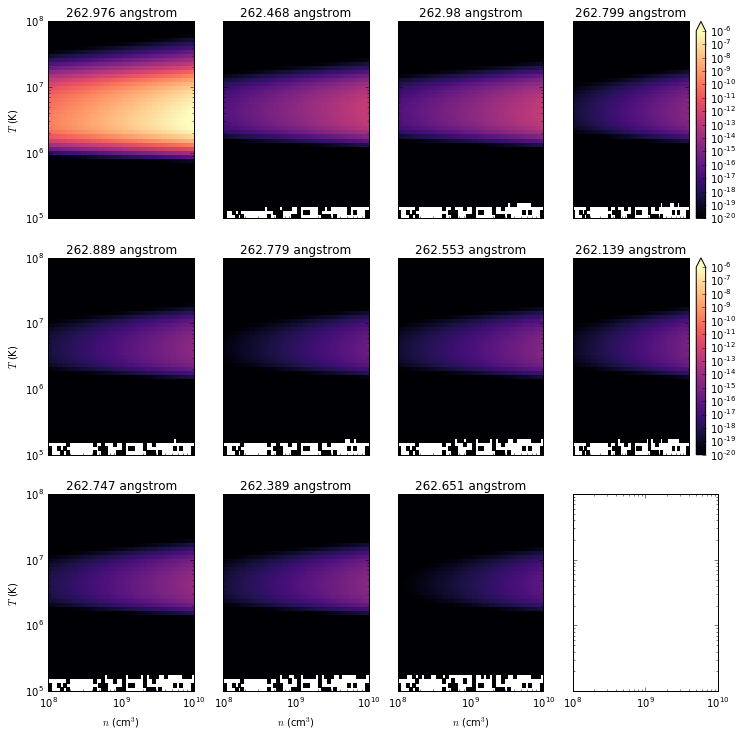

In [33]:
num_rows,num_cols=3,4
fig,axes = plt.subplots(num_rows,num_cols,figsize=(12,12),sharex=True,sharey=True)
for ax,i in zip(axes.flatten(),range(len(chianti_ion.Emiss['wvl']))):
    emiss0 = np.reshape(chianti_ion.Emiss['emiss'][i,:],temperature_mesh.shape)
    fractional_ionization = np.reshape(chianti_ion.IoneqOne,temperature_mesh.shape)
    emissivity = np.ma.masked_less_equal(emiss0*fractional_ionization*chianti_ion.Abundance*0.83*density_mesh,0)
    pcm = ax.pcolormesh(density_mesh,temperature_mesh,emissivity,
                    norm=matplotlib.colors.LogNorm(vmin=1e-20,vmax=1e-6),cmap='magma')
    if (i+1)%num_cols==0:
        fig.colorbar(pcm,ax=ax,extend='max')
    ax.set_title(r'{} angstrom'.format(chianti_ion.Emiss['wvl'][i]))
    ax.set_xscale('log')
    ax.set_yscale('log')
    if i%num_cols==0:
        ax.set_ylabel(r'$T$ (K)')
    if i>(num_rows-1)*num_cols-1:
        ax.set_xlabel(r'$n$ (cm$^3$)')
    ax.set_xlim([density[0],density[-1]])
    ax.set_ylim([temperature[0],temperature[-1]])

In [22]:
chianti_ion.Upsilon['upsilon'].shape

(9397, 4)

In [23]:
len(chianti_ion.Scups['lvl1'])

9397

In [24]:
((13.6*u.eV).to(u.erg)/(const.k_B.cgs))**(0.5)*2.172e-8

<Quantity 8.628649989612902e-06 K(1/2)>

SynthesizAR workflow will look something like this:

1. List number of ions with associated transitions that you want to calculate
2. For each ion, create an ion object with the appropriate temperature and density ranges
3. For each ion object, calculate the emissivity over the wavelength range appropriate for the desired transitions
4. For each ion object, calculate the ionization equilibrium as a function of temperature
5. At each time step in the loop evolution, interpolate the emissivity and fractional ionization at the desired temperature and density.